## Projeto Housing Prices - Geração dos Modelos

Este notebook tem como objetivo carregar os dados do case Housing Prices, preparar os dados, treinar dois modelos de regressão (Random Forest e LightGBM), e salvar os modelos treinados para serem utilizados em uma aplicação Flask.


### 1. Importação das Bibliotecas

Primeiramente, vamos importar todas as bibliotecas necessárias para o desenvolvimento do projeto.

In [132]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from pycaret.regression import *

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

### 2. Carregamento e vizualização inicial

Vamos carregar o dataset de preços de imóveis e fazer uma breve análise exploratória dos dados.

In [133]:
# Carrega os dados
df = pd.read_csv('house_pricing.csv')

In [134]:
# Visualiza as primeiras linhas do dataset
df.head()

price  num_bed  num_bath  size_house  size_lot  num_floors  \
0   239000        3       1.0        1510     15022         1.0   
1  1260000        3       3.5        3220      3960         2.0   
2   414500        3       1.0        1050      6002         1.0   
3   252500        3       2.5        1780      7192         1.0   
4   389000        3       1.0        1330      3740         1.5   

   is_waterfront  condition  size_basement  year_built  renovation_date  \
0              0          3              0        1962                0   
1              0          3            460        1991                0   
2              0          3            210        1941                0   
3              0          4            530        1974                0   
4              0          3              0        1903                0   

     zip   latitude   longitude  avg_size_neighbor_houses  \
0  98003  47.330433 -122.303609                      1510   
1  98116  47.590933 -122.384230                      3080   
2  98115  47.698761 -122.316010                      1180   
3  98031  47.409319 -122.173484                      1870   
4  98118  47.550242 -122.274232                      1330   

   avg_size_neighbor_lot  
0                  12970  
1                   4444  
2                   6003  
3                   8500  
4                   5053

#### Criação de variáveis para avaliação

In [135]:
# Criação de novas variáveis 'zip_prefix_x' contendo agrupamentos da variável 'zip'
df['zip_prefix_3'] = df['zip'].astype(str).str[:3].astype(int)
df['zip_prefix_4'] = df['zip'].astype(str).str[:4].astype(int)

In [136]:
# Visualização inicial para confirmar a criação das novas variáveis
df[['zip', 'zip_prefix_3', 'zip_prefix_4']].head()

zip  zip_prefix_3  zip_prefix_4
0  98003           980          9800
1  98116           981          9811
2  98115           981          9811
3  98031           980          9803
4  98118           981          9811

### 3. Análise descritiva da base de dados

Nesta seção, vamos realizar uma análise descritiva completa da base de dados de preços de imóveis. A análise incluirá a visualização inicial dos dados, estatísticas descritivas, verificação de valores nulos, distribuições das variáveis, correlações entre as variáveis e visualizações gráficas.


#### Análise das variáveis numéricas

In [137]:
# Estatísticas descritivas das variáveis númericas
df.describe()

price      num_bed     num_bath    size_house      size_lot  \
count  1.845000e+03  1845.000000  1845.000000   1845.000000  1.845000e+03   
mean   5.571270e+05     3.379946     2.140108   2128.444986  1.564250e+04   
std    4.032082e+05     0.939221     0.785074    955.754345  4.132393e+04   
min    8.100000e+04     0.000000     0.000000    410.000000  6.490000e+02   
25%    3.250000e+05     3.000000     1.750000   1440.000000  5.100000e+03   
50%    4.570000e+05     3.000000     2.250000   1950.000000  7.700000e+03   
75%    6.650000e+05     4.000000     2.500000   2620.000000  1.106000e+04   
max    7.062500e+06     9.000000     6.750000  10040.000000  1.024068e+06   

       num_floors  is_waterfront    condition  size_basement   year_built  \
count  1845.00000    1845.000000  1845.000000    1845.000000  1845.000000   
mean      1.51897       0.014092     3.382114     290.643902  1971.820054   
std       0.54952       0.117903     0.634172     461.995804    29.097993   
min       1.00000       0.000000     1.000000       0.000000  1900.000000   
25%       1.00000       0.000000     3.000000       0.000000  1952.000000   
50%       1.50000       0.000000     3.000000       0.000000  1976.000000   
75%       2.00000       0.000000     4.000000     550.000000  1997.000000   
max       3.50000       1.000000     5.000000    4820.000000  2015.000000   

       renovation_date           zip     latitude    longitude  \
count      1845.000000   1845.000000  1845.000000  1845.000000   
mean        108.143089  98076.913279    47.554031  -122.211944   
std         451.883314     53.930320     0.139691     0.141806   
min           0.000000  98001.000000    47.189960  -122.514798   
25%           0.000000  98031.000000    47.462603  -122.324186   
50%           0.000000  98065.000000    47.565811  -122.231426   
75%           0.000000  98118.000000    47.673289  -122.124664   
max        2014.000000  98199.000000    47.777140  -121.472967   

       avg_size_neighbor_houses  avg_size_neighbor_lot  zip_prefix_3  \
count               1845.000000            1845.000000   1845.000000   
mean                2022.428184           12909.130081    980.407046   
std                  704.367775           25949.820788      0.491417   
min                  780.000000             659.000000    980.000000   
25%                 1490.000000            5175.000000    980.000000   
50%                 1880.000000            7642.000000    980.000000   
75%                 2390.000000           10250.000000    981.000000   
max                 5790.000000          392040.000000    981.000000   

       zip_prefix_4  
count   1845.000000  
mean    9807.189160  
std        5.318846  
min     9800.000000  
25%     9803.000000  
50%     9806.000000  
75%     9811.000000  
max     9819.000000

In [138]:
# Verificação de valores nulos
df.isnull().sum()

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
zip_prefix_3                0
zip_prefix_4                0
dtype: int64

Vamos visualizar a distribuição das variáveis numéricas utilizando histogramas.


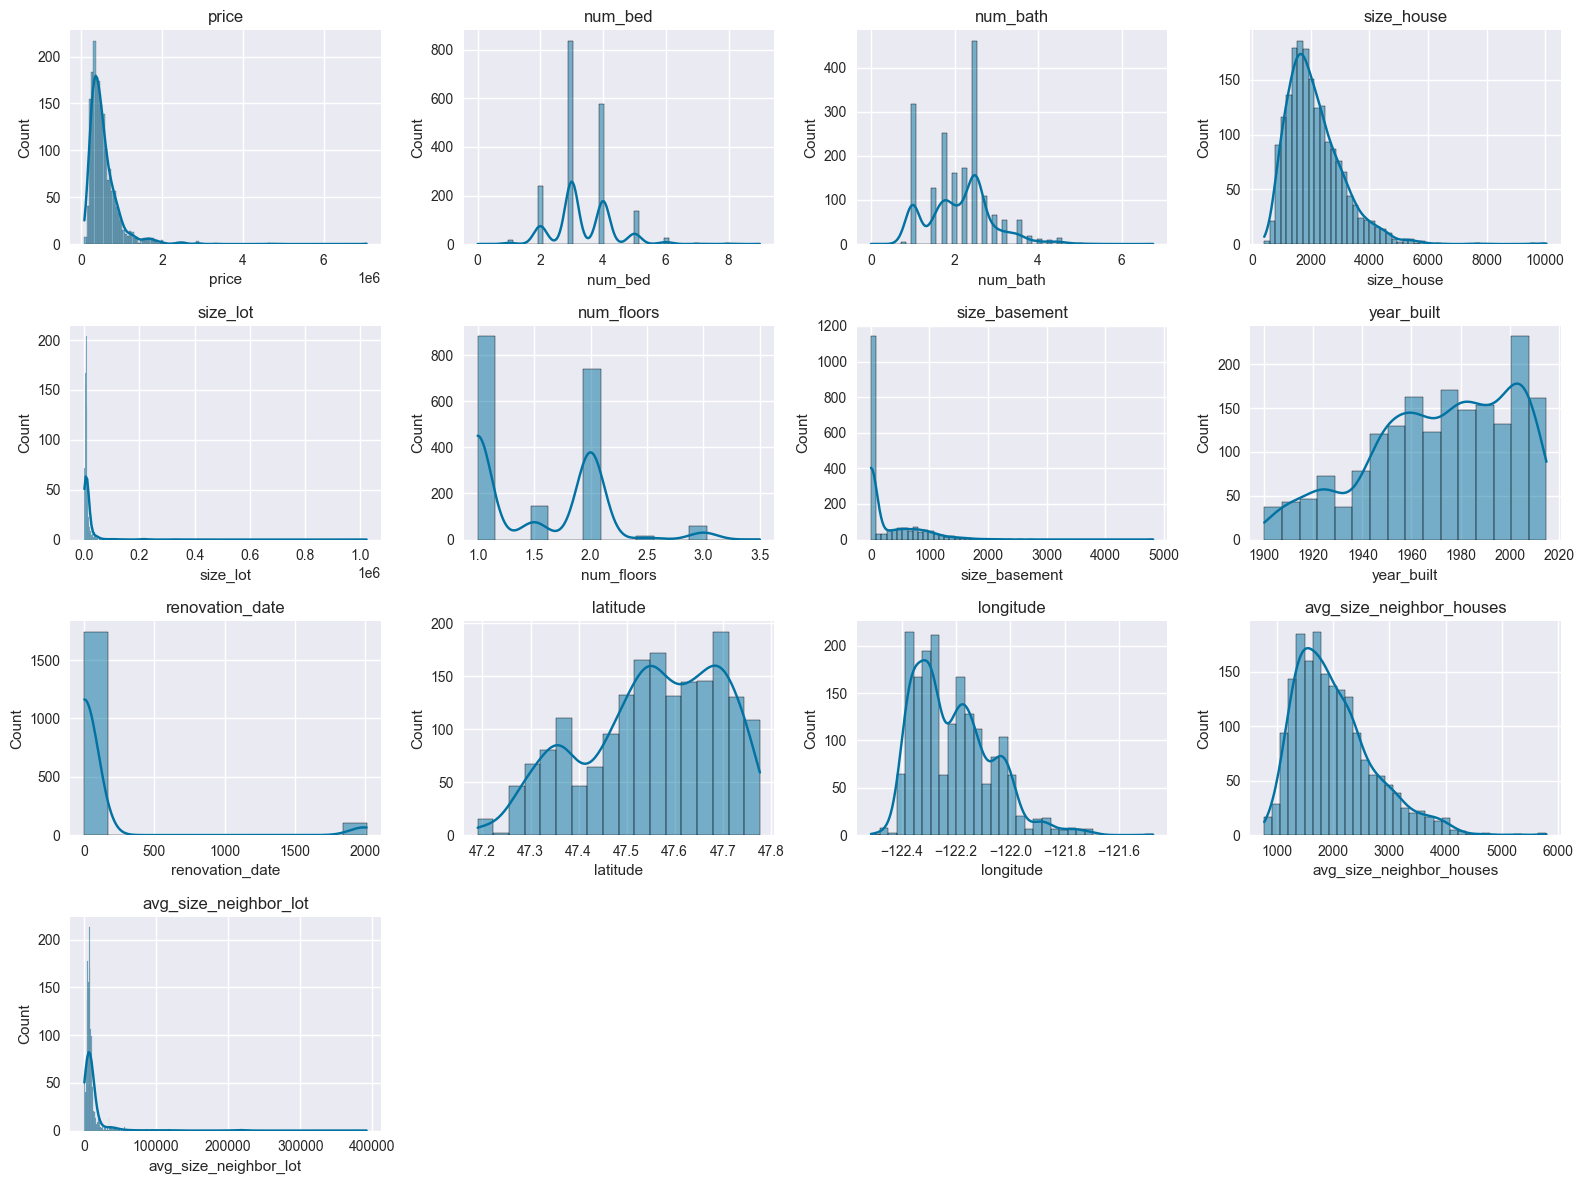

In [139]:
# Configuração dos gráficos
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16, 12))

# Lista de variáveis numéricas
numeric_columns = [
    'price', 'num_bed', 'num_bath', 'size_house', 'size_lot',
    'num_floors', 'size_basement', 'year_built', 'renovation_date',
    'latitude', 'longitude', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot'
]

# Plota histogramas
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

#### Análise das variáveis categóricas

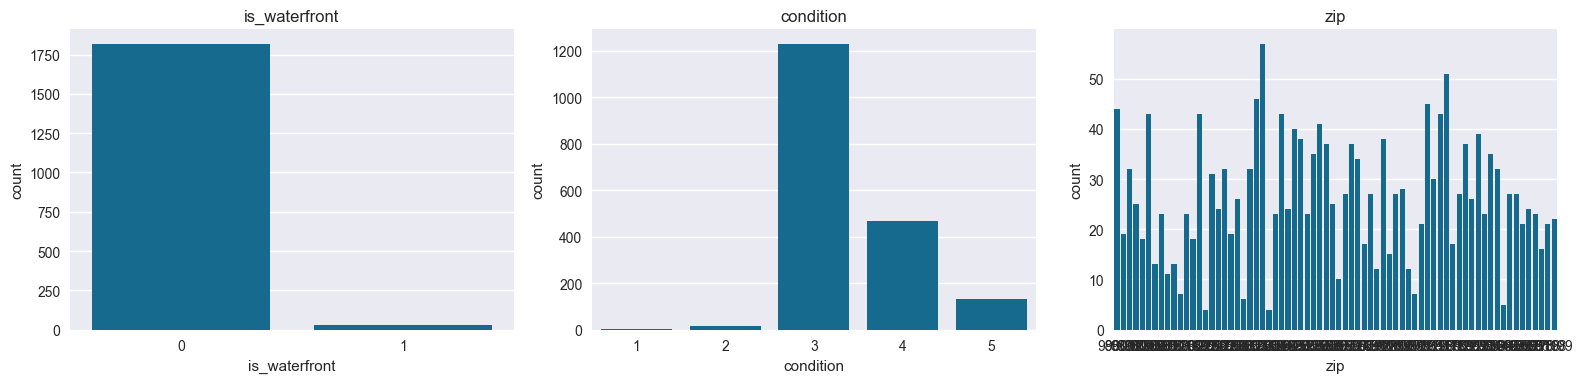

In [140]:
# Verificação de variáveis categóricas
categorical_columns = ['is_waterfront', 'condition', 'zip', 'zip_prefix_3', 'zip_prefix_4']
categorical_columns_1 = ['is_waterfront', 'condition', 'zip']
categorical_columns_2 = ['zip_prefix_3', 'zip_prefix_4']

# Plota frequencias
plt.figure(figsize=(16, 4))

for i, column in enumerate(categorical_columns_1, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Cria novas variáveis para verificar importância

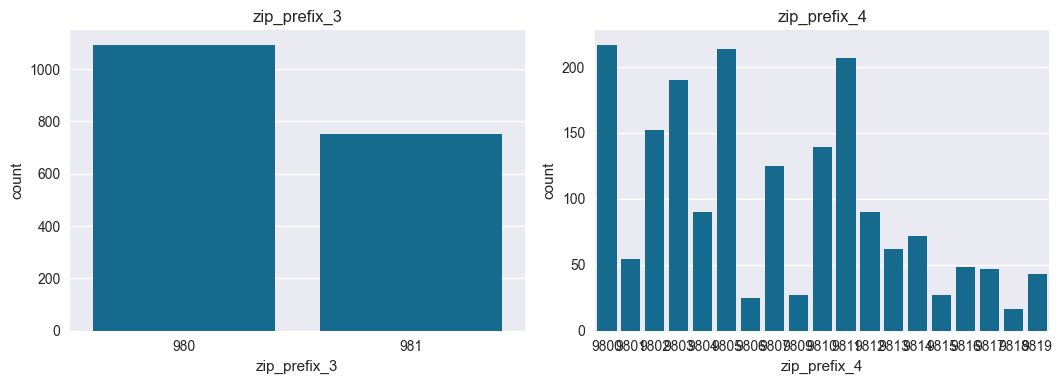

In [141]:
# Plota frequencias
plt.figure(figsize=(16, 4))

for i, column in enumerate(categorical_columns_2, 1):
    plt.subplot(1, 3, i)
    sns.countplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

#### Correlações entre as variáveis

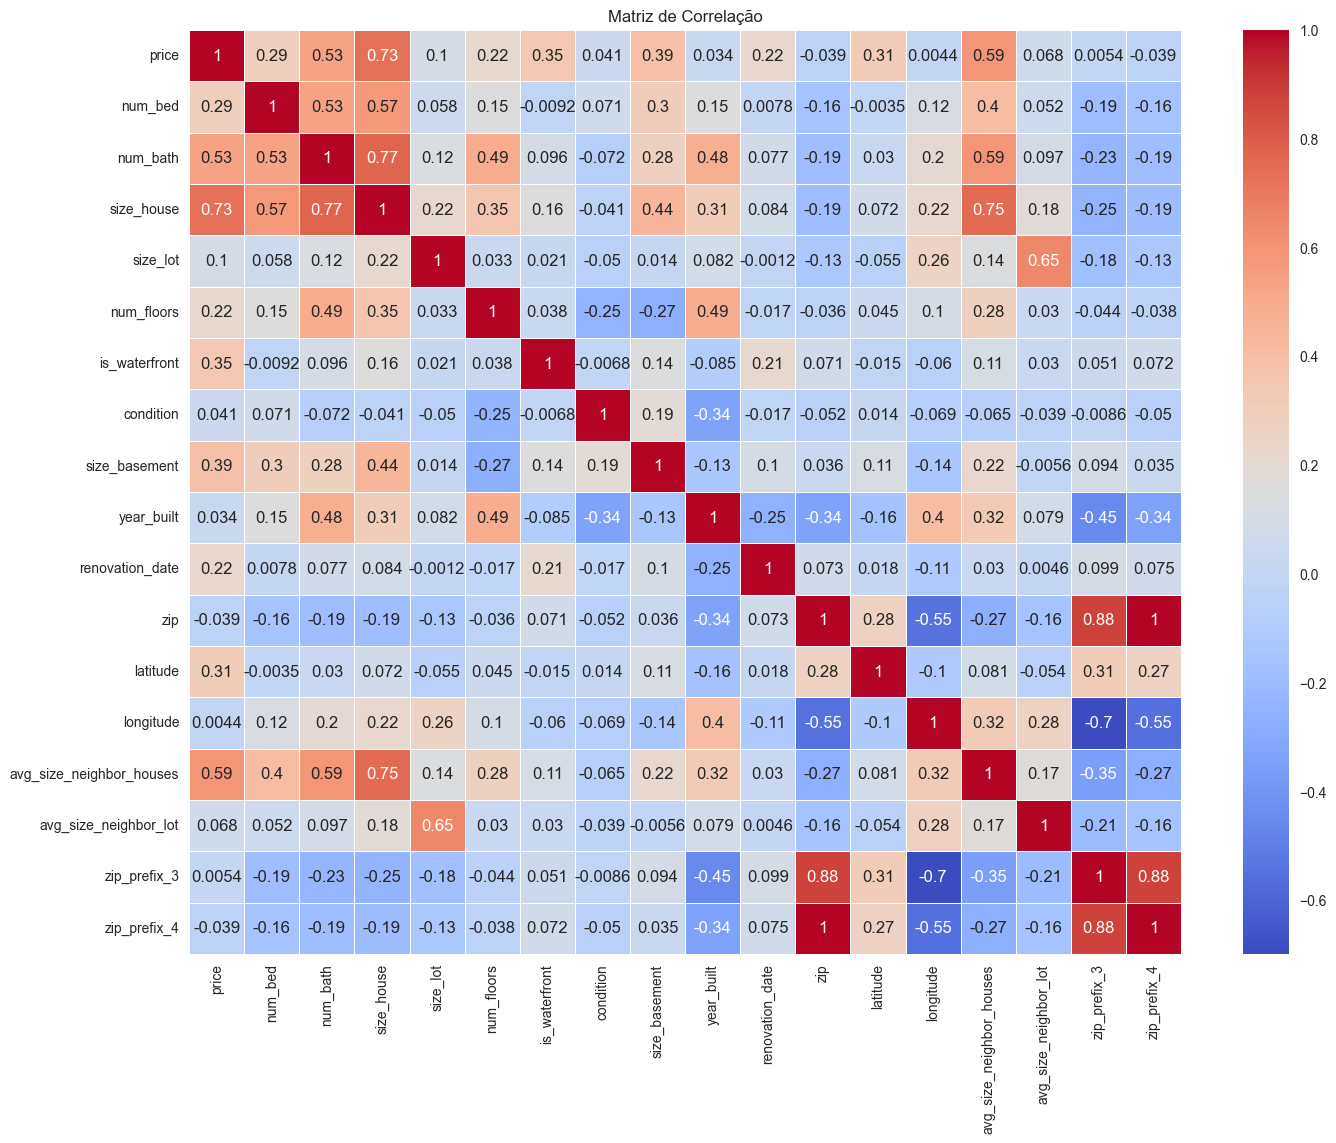

In [142]:
# Matriz de correlação
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()

# Heatmap da matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

#### Scatterplots para variáveis de interesse


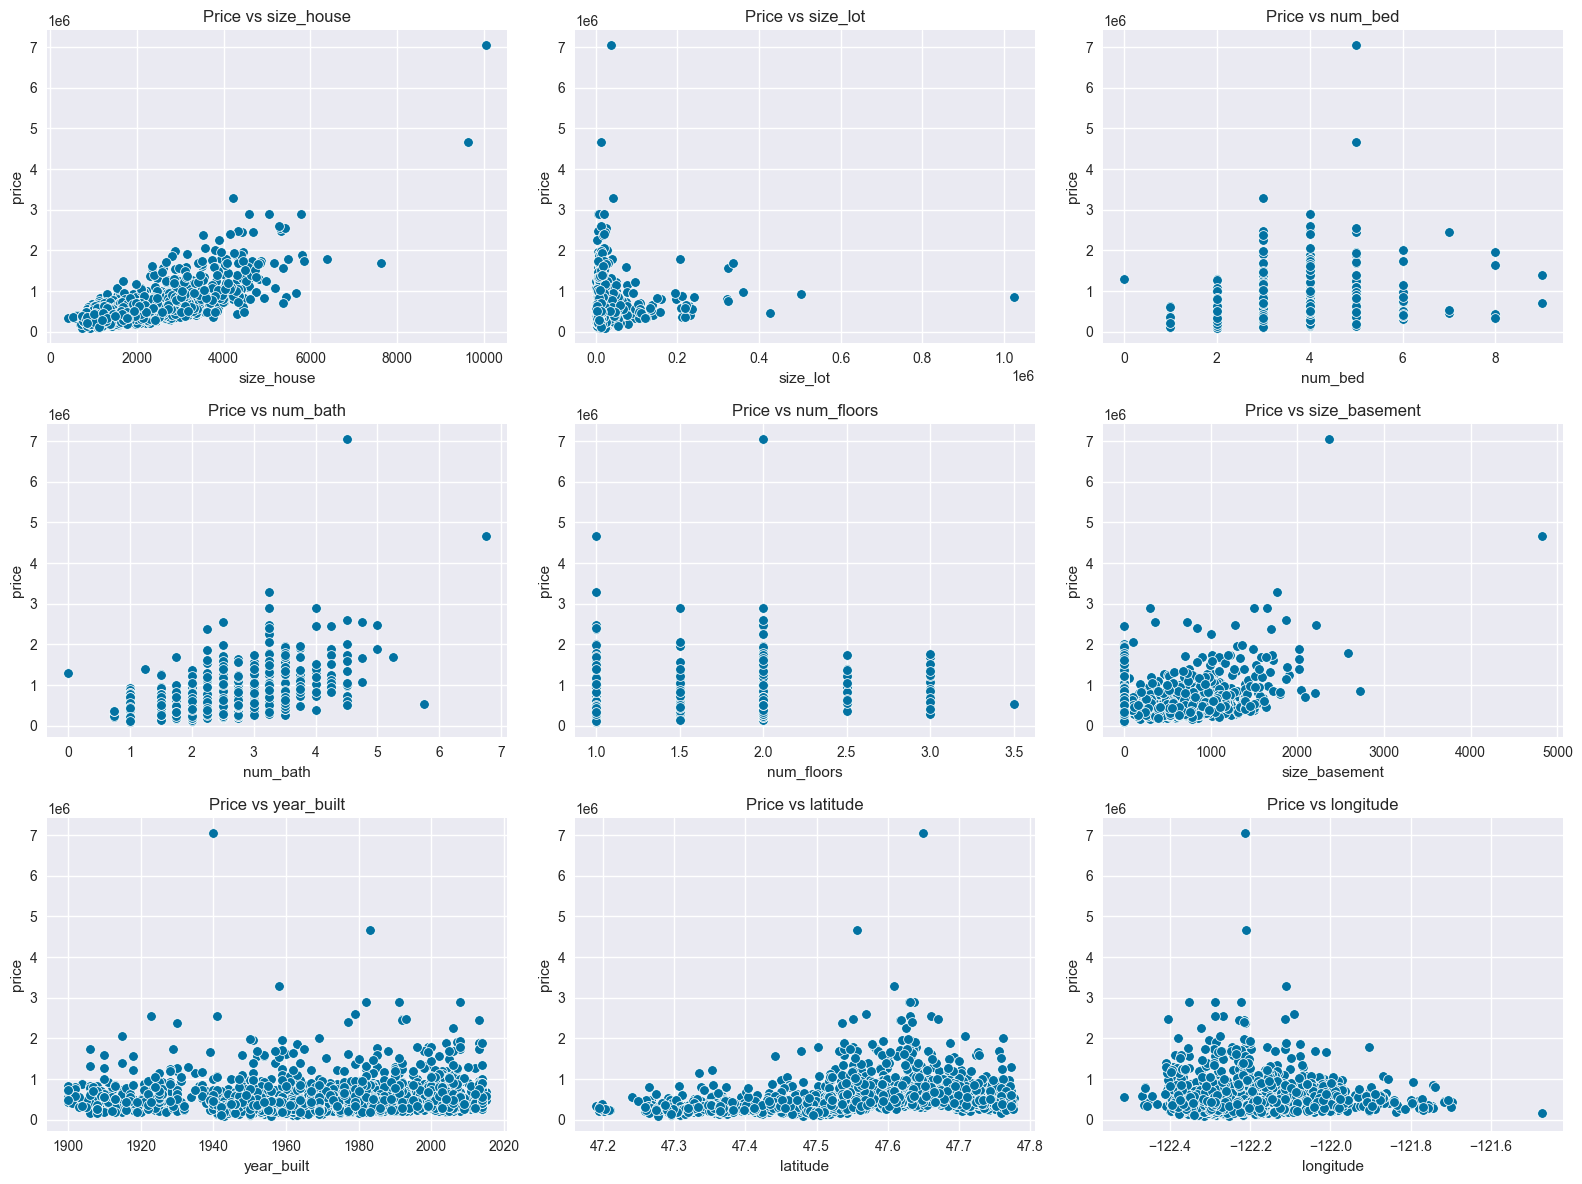

In [143]:
# Scatterplots
plt.figure(figsize=(16, 12))

variables_of_interest = [
    'size_house', 'size_lot', 'num_bed', 'num_bath',
    'num_floors', 'size_basement', 'year_built', 'latitude', 'longitude'
]

for i, column in enumerate(variables_of_interest, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[column], y=df['price'])
    plt.title(f'Price vs {column}')

plt.tight_layout()
plt.show()

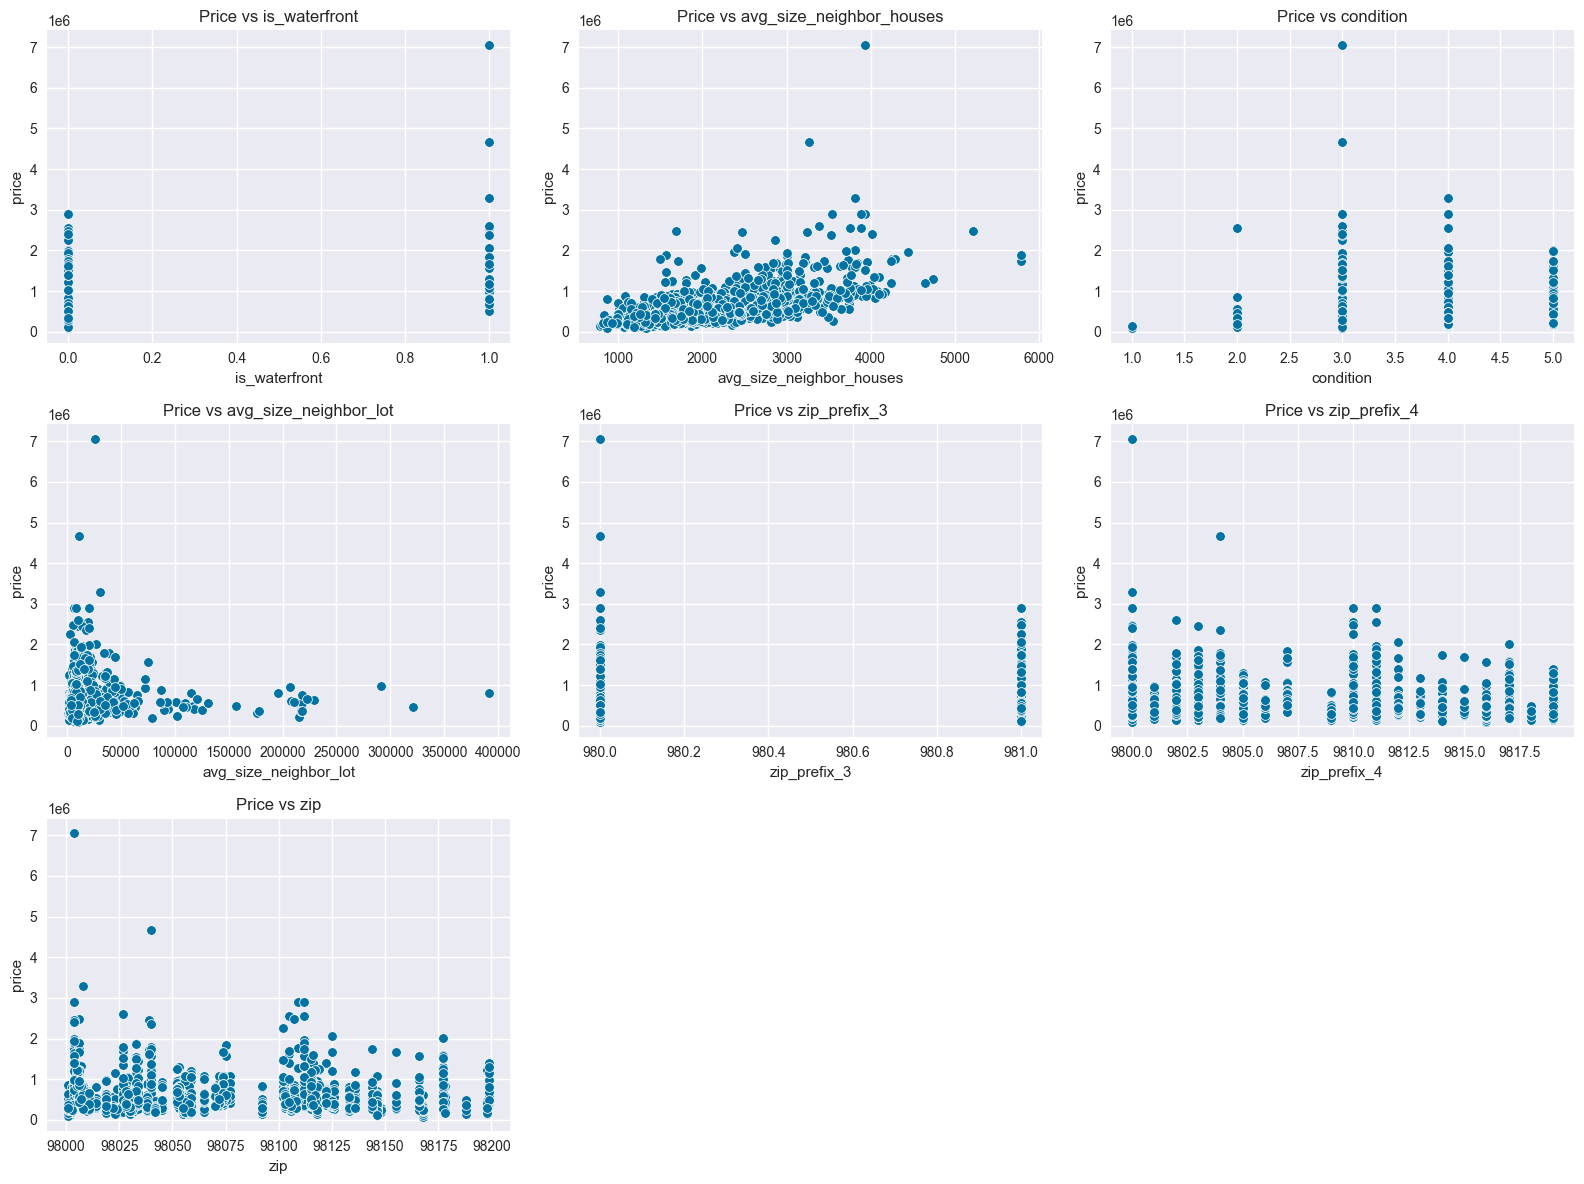

In [144]:
# Scatterplots
plt.figure(figsize=(16, 12))

variables_of_interest = [
    'is_waterfront', 'avg_size_neighbor_houses', 'condition','avg_size_neighbor_lot',
    'zip_prefix_3', 'zip_prefix_4', 'zip'
]

for i, column in enumerate(variables_of_interest, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[column], y=df['price'])
    plt.title(f'Price vs {column}')

plt.tight_layout()
plt.show()

#### Boxplots para detecção de outliers

Vamos utilizar boxplots para detectar possíveis outliers nas variáveis numéricas.

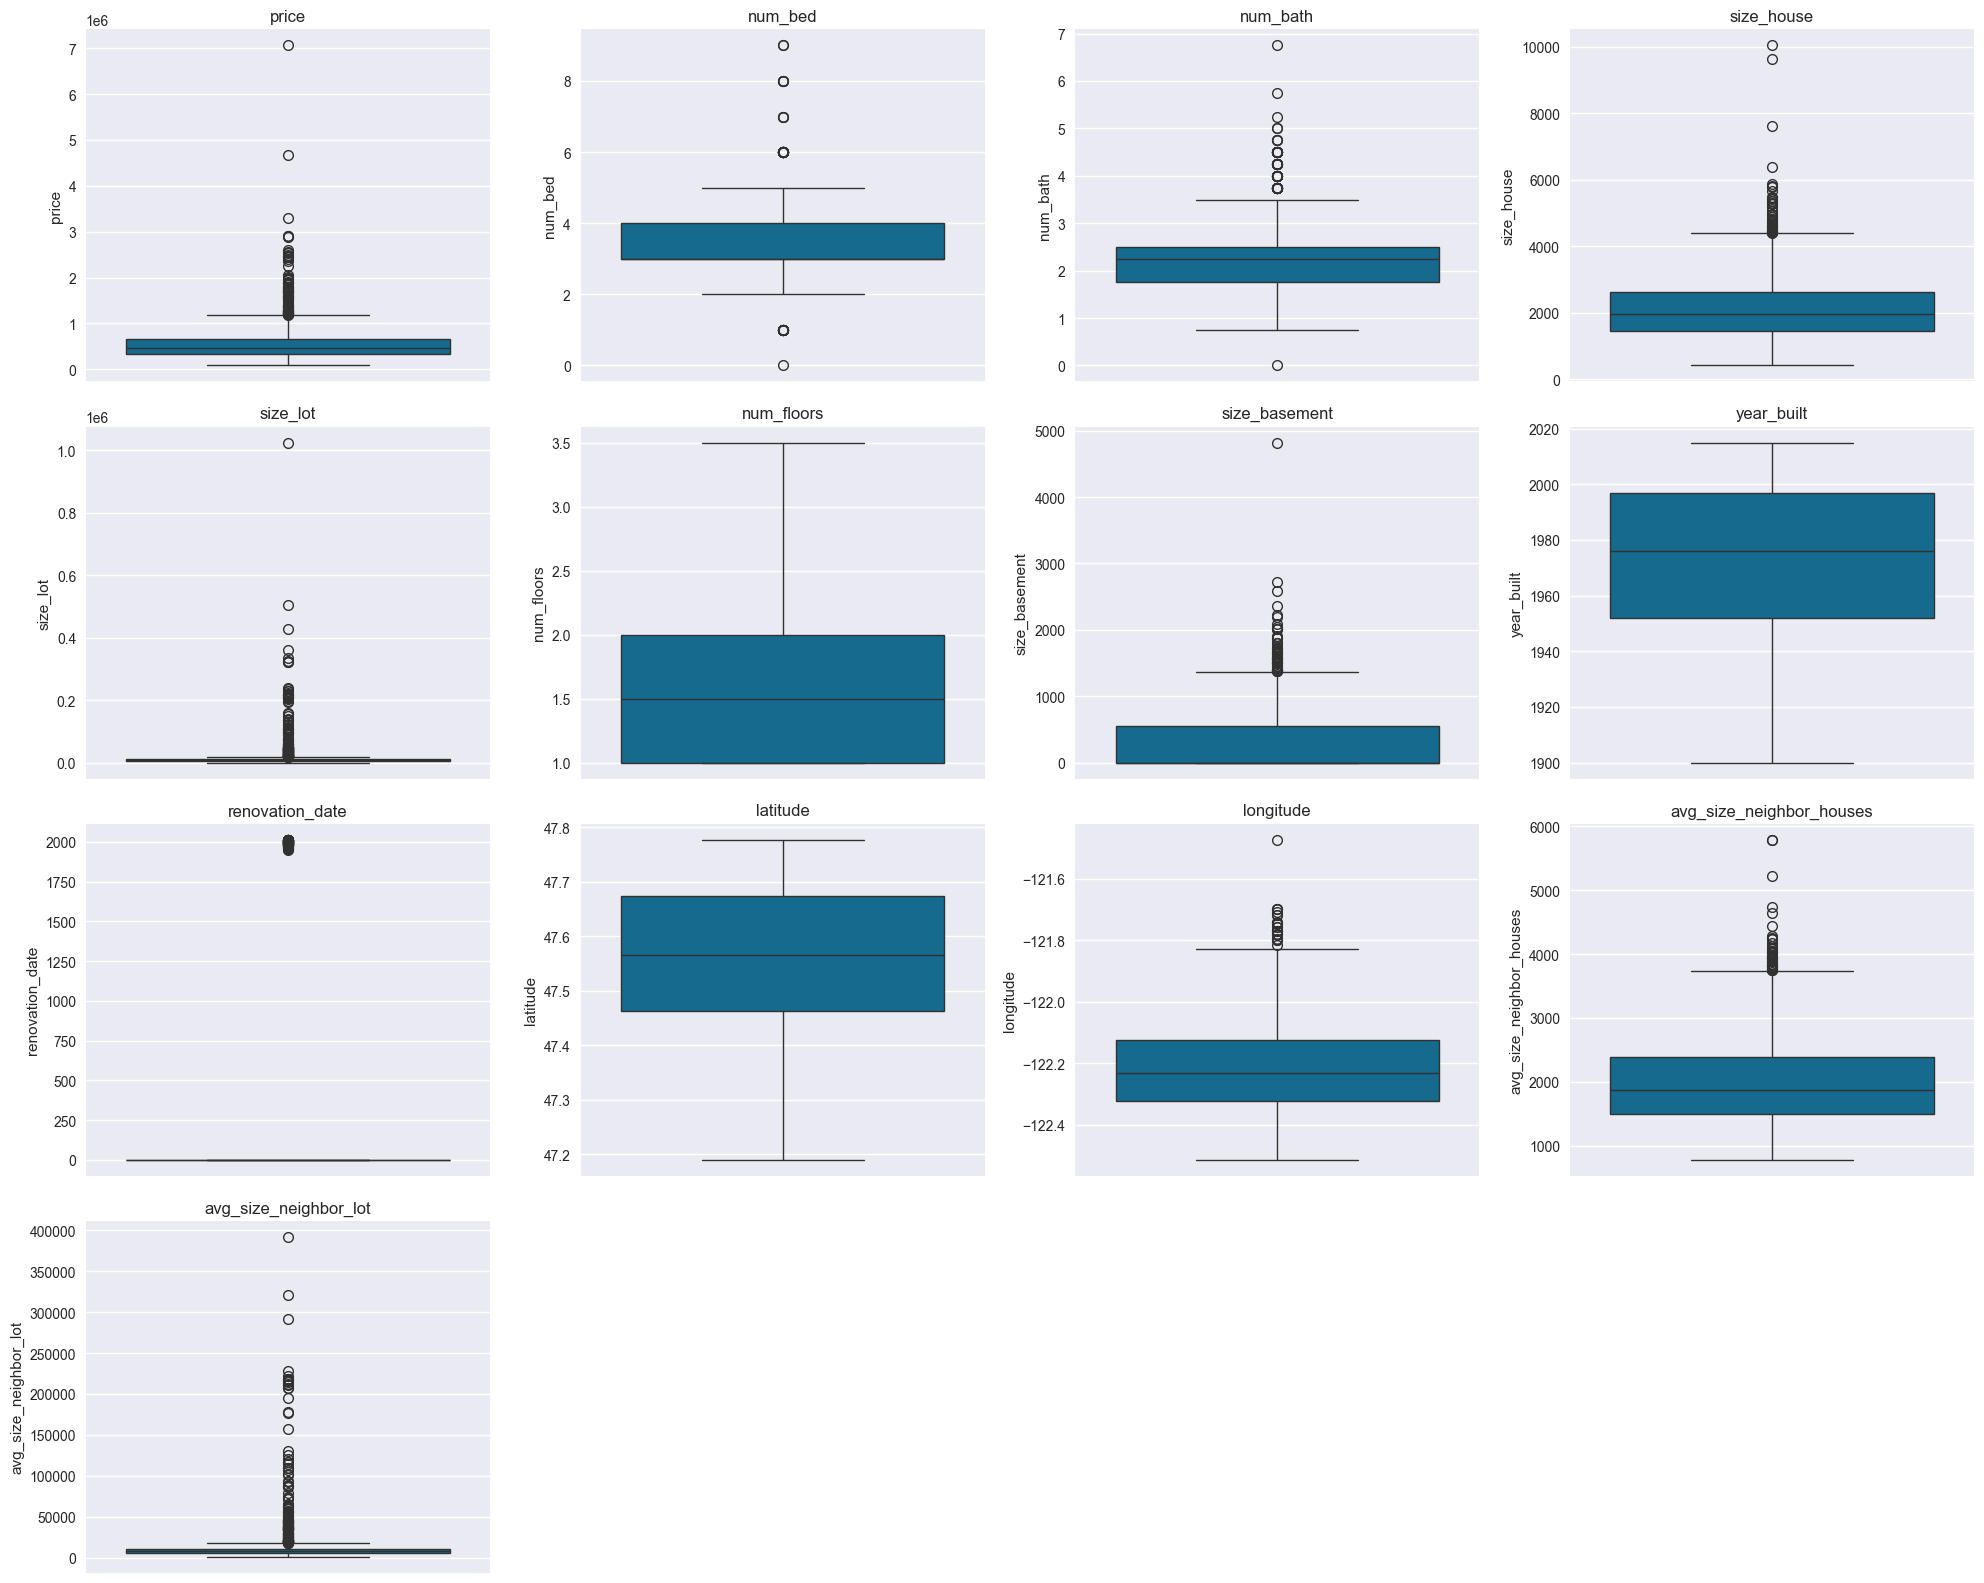

In [145]:
# Boxplots
plt.figure(figsize=(20, 16))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

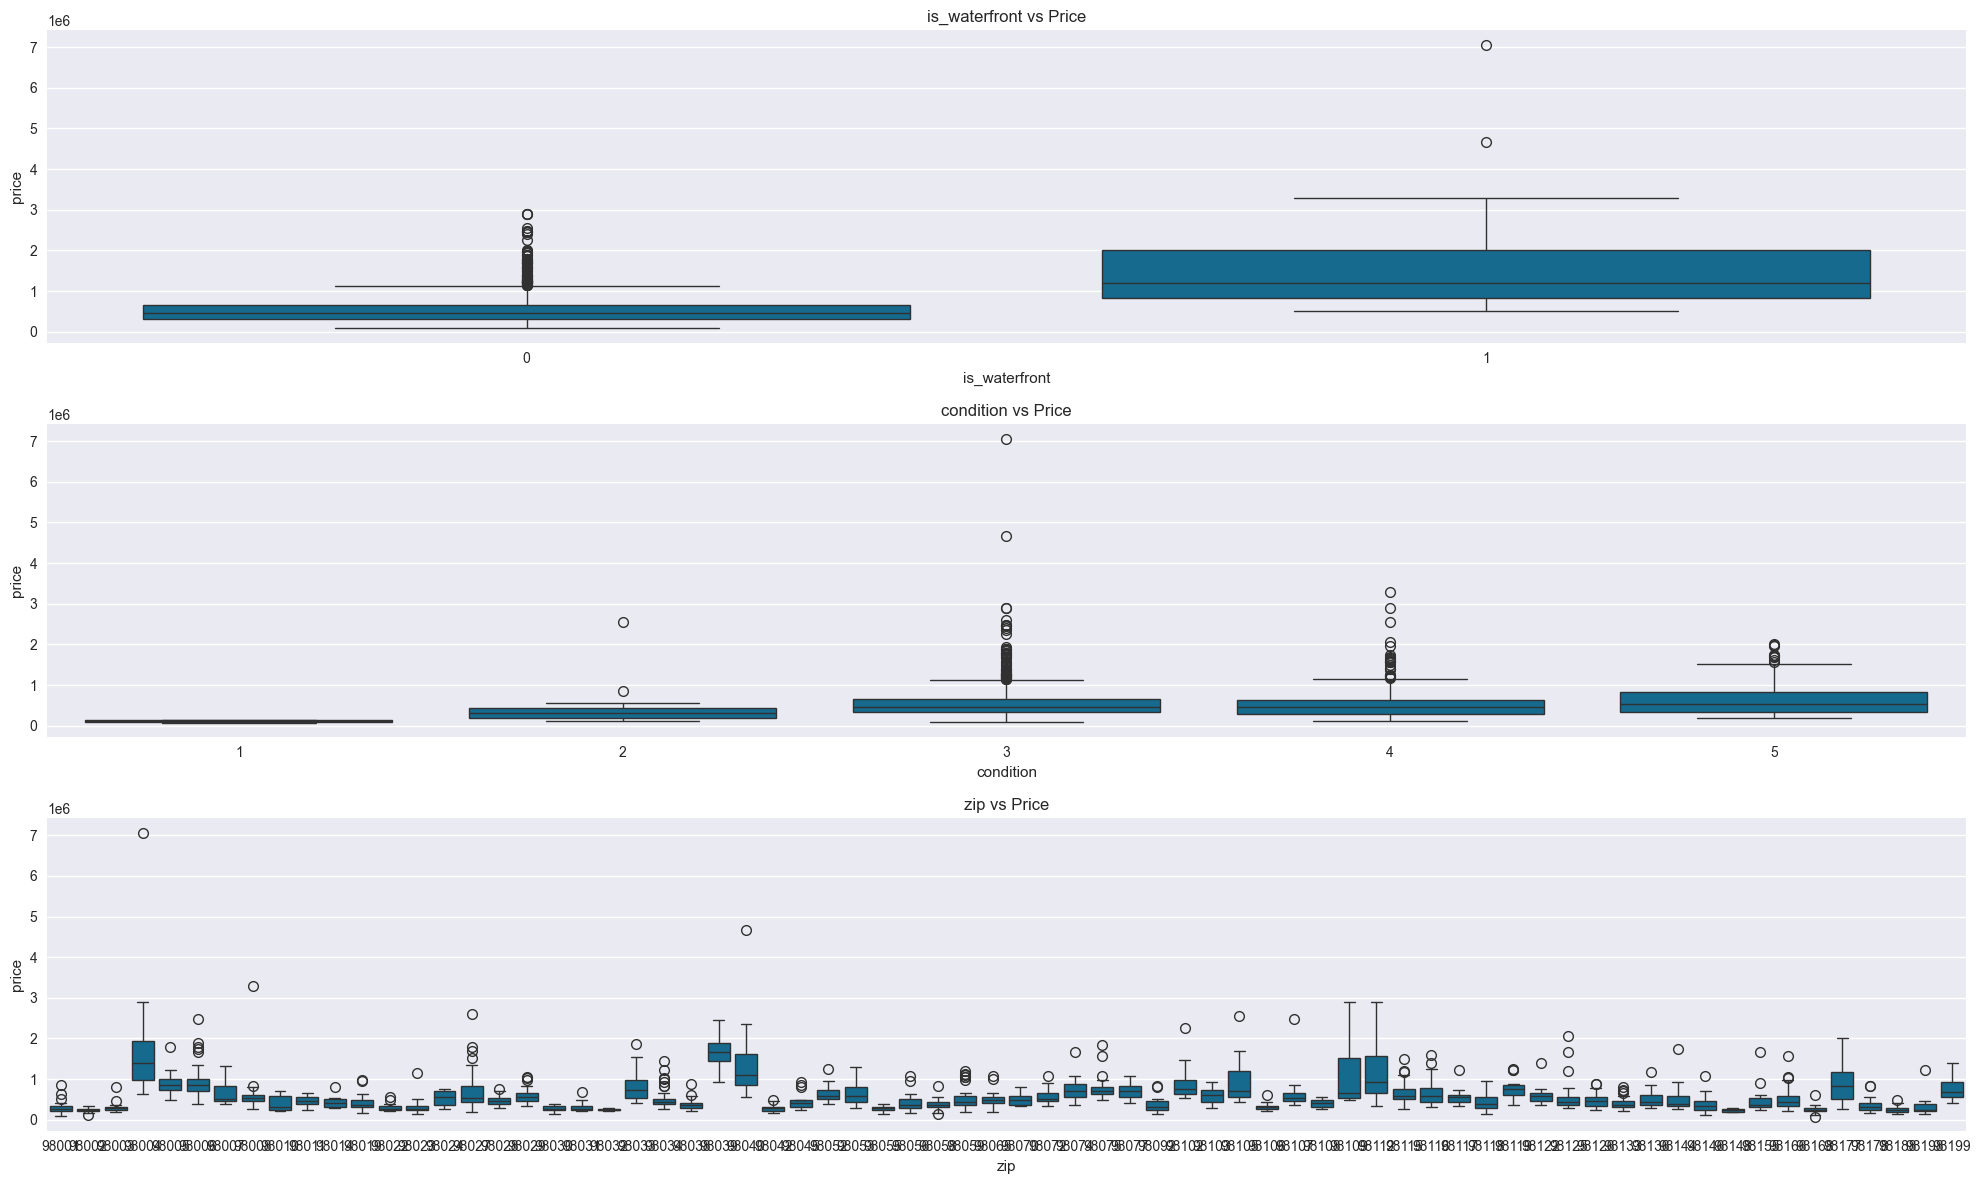

In [146]:
# Relação entre variáveis categóricas e o preço
plt.figure(figsize=(20, 12))

for i, column in enumerate(categorical_columns_1, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=df[column], y=df['price'])
    plt.title(f'{column} vs Price')

plt.tight_layout()
plt.show()

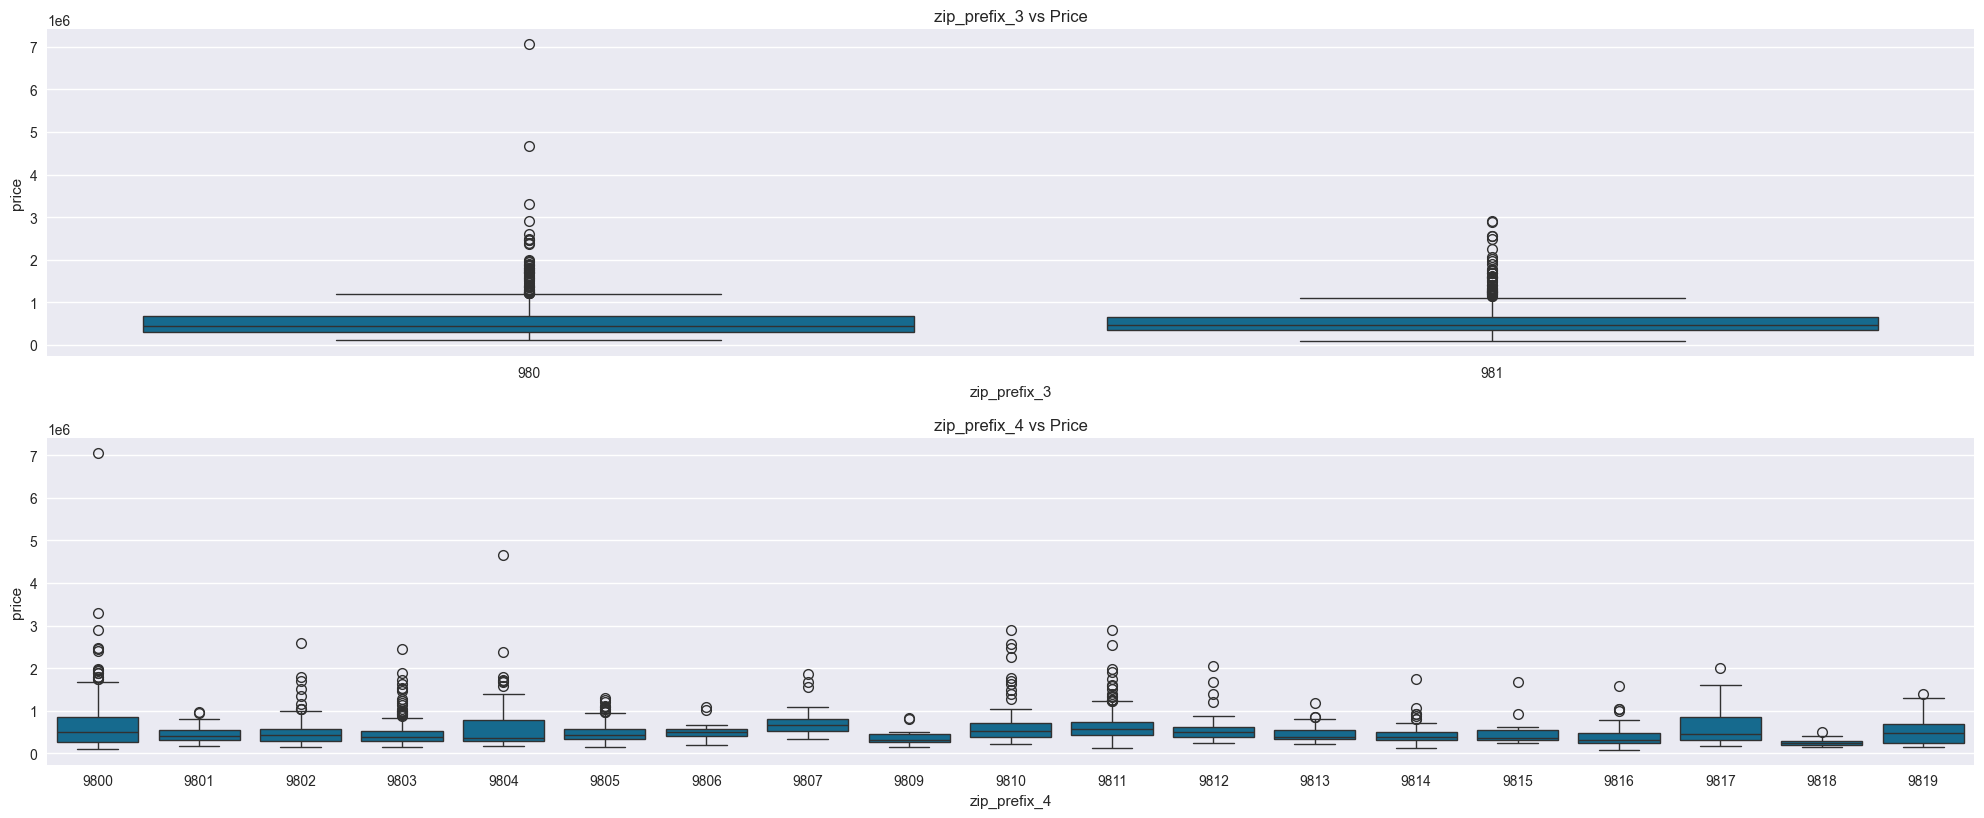

In [147]:
# Relação entre variáveis categóricas e o preço
plt.figure(figsize=(20, 12))

for i, column in enumerate(categorical_columns_2, 1):
    plt.subplot(3, 1, i)
    sns.boxplot(x=df[column], y=df['price'])
    plt.title(f'{column} vs Price')

plt.tight_layout()
plt.show()

#### Distribuição conjunta de longitude e latitude

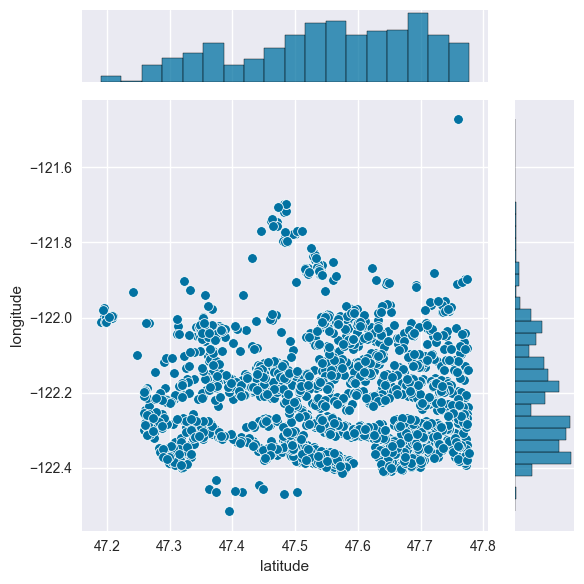

In [148]:
# Distribuições conjuntas
correlated_pairs = [('latitude', 'longitude')]

for i, (x, y) in enumerate(correlated_pairs, 1):
    sns.jointplot(x=df[x], y=df[y], kind='scatter')

plt.tight_layout()

#### Pairplot para Análise Geral
Vamos utilizar pairplots para uma visão geral das inter-relações entre as variáveis.


<Figure size 2000x1600 with 0 Axes>

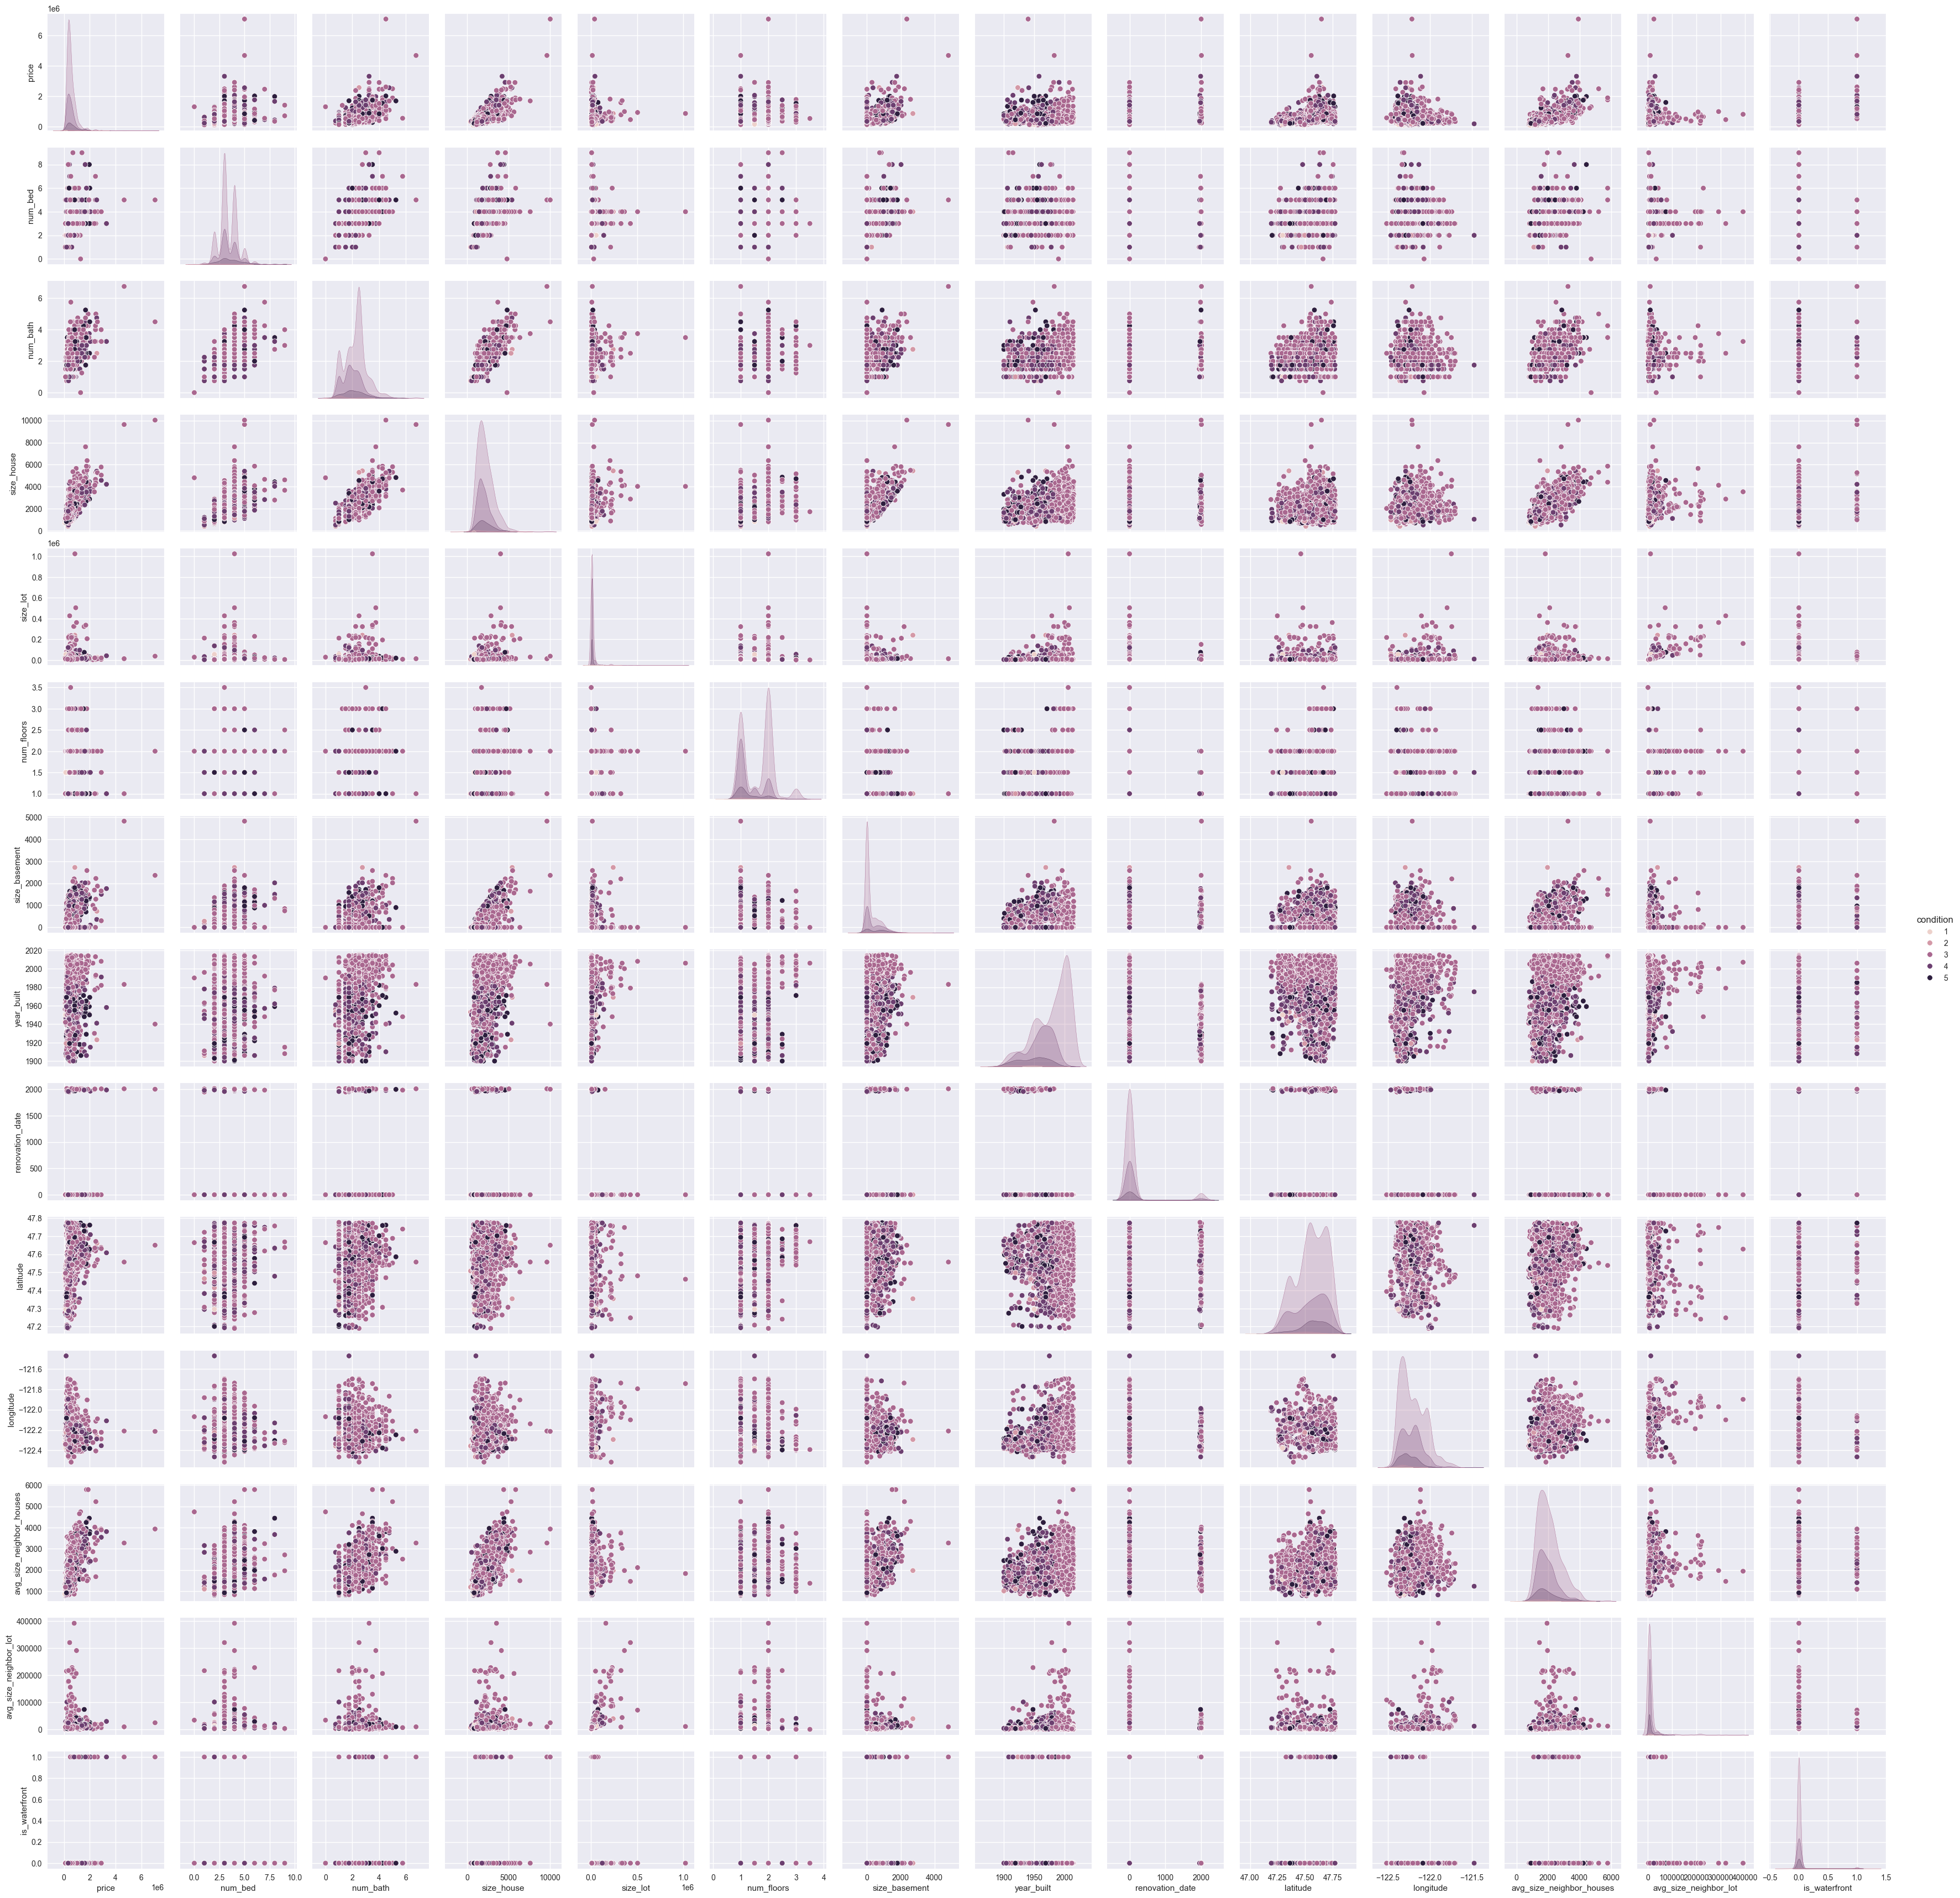

In [149]:
# Pairplot
plt.figure(figsize=(20, 16))
sns.pairplot(df[numeric_columns + ['is_waterfront', 'condition']], hue='condition')
plt.show()

### 4. Tratamento dos dados

#### Remoção de Outliers

Vamos remover os outliers das variáveis numéricas utilizando o método IQR (Interquartile Range).

In [150]:
# Função para remover outliers com base no IQR
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

# Remover outliers
df_clean = remove_outliers(df, numeric_columns)

# Verificar o tamanho do dataframe após remoção de outliers
print(f'Tamanho original do dataframe: {df.shape}')
print(f'Tamanho do dataframe após remoção de outliers: {df_clean.shape}')

Tamanho original do dataframe: (1845, 18)
Tamanho do dataframe após remoção de outliers: (1370, 18)


#### Normalização dos Dados

Vamos normalizar as variáveis numéricas para que todas tenham a mesma escala.

In [151]:
# Normalizar as variáveis numéricas
scaler = StandardScaler()
df_clean[numeric_columns] = scaler.fit_transform(df_clean[numeric_columns])

# Visualizar os dados normalizados
df_clean.head()

price   num_bed  num_bath  size_house  size_lot  num_floors  \
0 -1.091748 -0.326661 -1.519402   -0.552779  2.318888   -0.897847   
2 -0.211178 -0.326661 -1.519402   -1.232300 -0.325729   -0.897847   
3 -1.024012 -0.326661  0.774351   -0.153930  0.023173   -0.897847   
4 -0.339124 -0.326661 -1.519402   -0.818679 -0.988936    0.000656   
5  0.240898  2.216098  1.538935    0.702858 -0.619510   -0.897847   

   is_waterfront  condition  size_basement  year_built  renovation_date  \
0              0          3      -0.646166   -0.361060              0.0   
2              0          3      -0.055085   -1.076959              0.0   
3              0          4       0.845609    0.048025              0.0   
4              0          3      -0.646166   -2.372396              0.0   
5              0          3       2.084064    1.207100              0.0   

     zip  latitude  longitude  avg_size_neighbor_houses  \
0  98003 -1.561263  -0.606847                 -0.627318   
2  98115  1.063482  -0.704730                 -1.210084   
3  98031 -0.999115   0.420275                  0.008428   
4  98118  0.005116  -0.374960                 -0.945190   
5  98103  1.023155  -0.818190                  0.555875   

   avg_size_neighbor_lot  zip_prefix_3  zip_prefix_4  
0               2.035679           980          9800  
2              -0.310875           981          9811  
3               0.530139           980          9803  
4              -0.630844           981          9811  
5              -0.645664           981          9810

In [152]:
# Substitui a base original pela base com tratamentos
df = df_clean
df.shape

(1370, 18)

### 5. Construção dos modelos utilizando sklearn

Nesta seção, vamos dividir os dados em conjuntos de treino e teste, treinar dois modelos de regressão (Random Forest e LightGBM), avaliar os modelos utilizando métricas de desempenho, visualizar os resultados das previsões e salvar os modelos treinados.

In [153]:
# Divide os dados em variáveis dependentes (X) e variável alvo (y)
X = df.drop('price', axis=1)
y = df['price']

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifica o tamanho dos conjuntos
print(f'Tamanho do conjunto de treino: {X_train.shape}')
print(f'Tamanho do conjunto de teste: {X_test.shape}')

Tamanho do conjunto de treino: (1096, 17)
Tamanho do conjunto de teste: (274, 17)


#### Treinamento do modelo Random Forest


Vamos inicialmente treinar um modelo básico para termos uma ideia

In [154]:
# Instancia o modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treina o modelo Random Forest
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [155]:
# Faz previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)

In [156]:
# Calcula o erro quadrático médio (MSE) e o R²
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = rf_model.score(X_test, y_test)

print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R² Score: {r2_rf}')

Random Forest - Mean Squared Error: 0.15866419223941622
Random Forest - R² Score: 0.8102624300861966


Vamos verificar a importancia das variáveis e definir um threshold

In [157]:
# Obter as importâncias das features
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Criar um DataFrame para visualizar as importâncias das features
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print(importances_df)

                     Feature  Importance
11                  latitude    0.430330
2                 size_house    0.320914
13  avg_size_neighbor_houses    0.086377
12                 longitude    0.038073
8                 year_built    0.034793
3                   size_lot    0.014902
10                       zip    0.014116
7              size_basement    0.013743
14     avg_size_neighbor_lot    0.013205
5              is_waterfront    0.007458
1                   num_bath    0.007171
0                    num_bed    0.006853
16              zip_prefix_4    0.004752
6                  condition    0.003525
4                 num_floors    0.003039
15              zip_prefix_3    0.000748
9            renovation_date    0.000000


In [158]:
# Define um limite de importância para selecionar as features
importance_threshold = 0.03

# Seleciona as features importantes
important_features = importances_df[importances_df['Importance'] > importance_threshold]['Feature']
print(f'Features importantes selecionadas: {list(important_features)}')

# Filtra os dados de treino e teste para incluir apenas as features importantes
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

Features importantes selecionadas: ['latitude', 'size_house', 'avg_size_neighbor_houses', 'longitude', 'year_built']


Agora vamos usar um grid aleatório para tentar encontrar melhores hiperparamentros ainda com todas as features

In [159]:
# Definição da grid de hiperparâmetros para o RandomizedSearchCV
n_estimators = [10, 30, 100, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [5, 15, 30, 50]
min_samples_leaf = [1, 2, 5, 10]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

In [160]:
# Instancia o modelo Random Forest
rfr = RandomForestRegressor(random_state=42)

# Configuração do RandomizedSearchCV
rfr_tuned = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Treina o modelo com RandomizedSearchCV
rfr_tuned.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_params_rf = rfr_tuned.best_params_
print(f'Melhores hiperparâmetros: {best_params_rf}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores hiperparâmetros: {'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}


In [161]:
# Faz previsões no conjunto de teste com o melhor modelo
y_pred_rf_tuned = rfr_tuned.predict(X_test)

# Calcula o erro quadrático médio (MSE) e o R²
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = rfr_tuned.score(X_test, y_test)

print(f'Random Forest Tunado - Mean Squared Error: {mse_rf_tuned}')
print(f'Random Forest Tunado - R² Score: {r2_rf_tuned}')

Random Forest Tunado - Mean Squared Error: 0.18354761022606825
Random Forest Tunado - R² Score: 0.7805057522038137


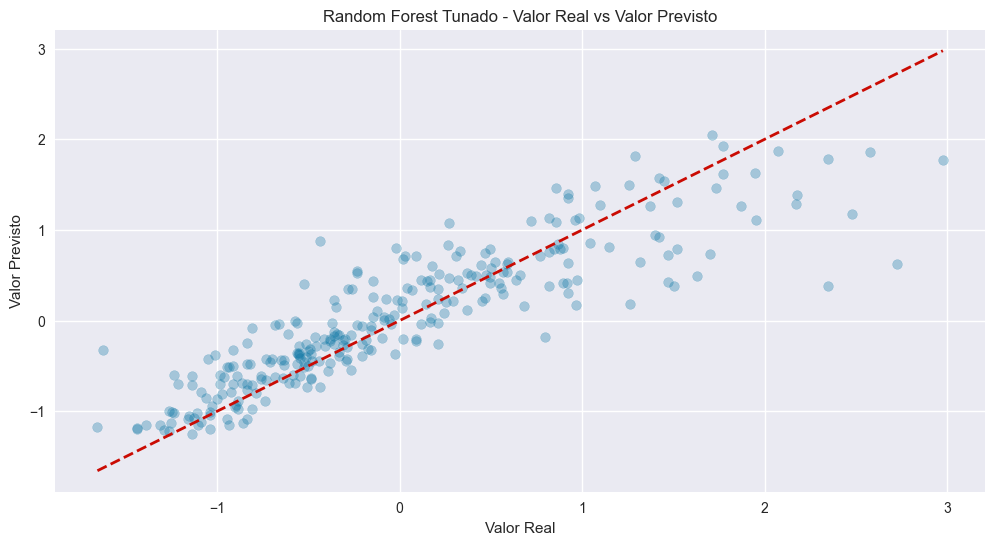

In [162]:
# Visualização das previsões do Random Forest Tunado
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_rf_tuned, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Random Forest Tunado - Valor Real vs Valor Previsto')
plt.show()

Agora vamos aplicar as features mais importantes para verificar se há perda de discriminação relevante

In [163]:
# Instanciar o modelo Random Forest
rfr_important = RandomForestRegressor(random_state=42)

# Configuração do RandomizedSearchCV com features selecionadas
rfr_tuned_important = RandomizedSearchCV(
    estimator=rfr_important,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo com RandomizedSearchCV
rfr_tuned_important.fit(X_train_important, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_params_rf_important = rfr_tuned_important.best_params_
print(f'Melhores hiperparâmetros com features selecionadas: {best_params_rf_important}')

# Fazer previsões no conjunto de teste com o melhor modelo
y_pred_rf_tuned_important = rfr_tuned_important.predict(X_test_important)

# Calcular o erro quadrático médio (MSE) e o R²
mse_rf_tuned_important = mean_squared_error(y_test, y_pred_rf_tuned_important)
r2_rf_tuned_important = rfr_tuned_important.score(X_test_important, y_test)

print(f'Random Forest Tunado com Features Selecionadas - Mean Squared Error: {mse_rf_tuned_important}')
print(f'Random Forest Tunado com Features Selecionadas - R² Score: {r2_rf_tuned_important}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores hiperparâmetros com features selecionadas: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Random Forest Tunado com Features Selecionadas - Mean Squared Error: 0.16663267685870392
Random Forest Tunado com Features Selecionadas - R² Score: 0.8007333681963043


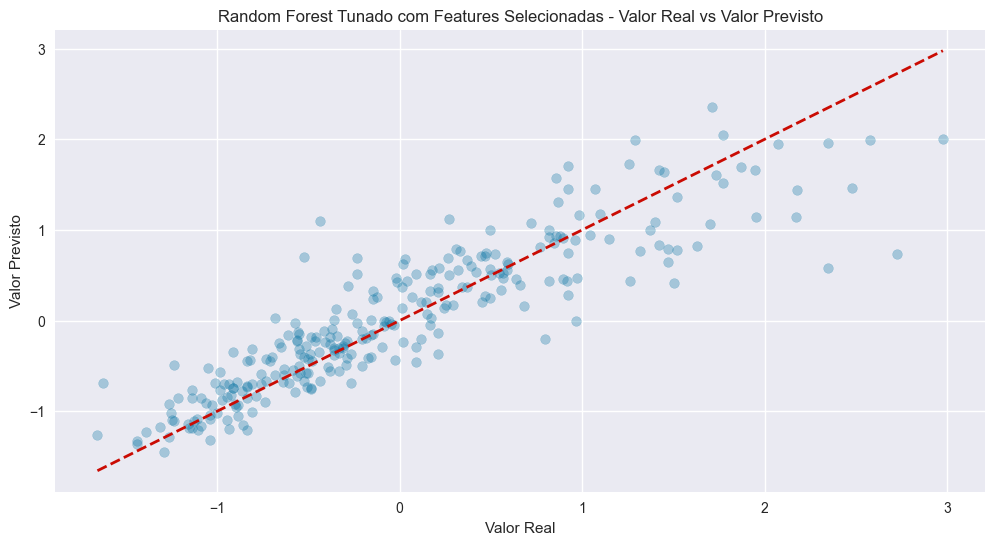

In [164]:
# Visualização das previsões do Random Forest Tunado com Features Selecionadas
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_rf_tuned_important, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Random Forest Tunado com Features Selecionadas - Valor Real vs Valor Previsto')
plt.show()

#### Treinamento do modelo LGBM - Light Gradient Boosting Machine

Vamos construir o modelo LightGBM (LGBM) seguindo a mesma estrutura que utilizamos para o Random Forest. A estrutura incluirá a definição da grid de hiperparâmetros, treinamento inicial para obter importâncias das features, seleção de features importantes, otimização dos hiperparâmetros com RandomizedSearchCV, treinamento com features selecionadas, e avaliação dos modelos.

In [165]:
# Instanciar o modelo LightGBM inicial
lgb_initial = lgb.LGBMRegressor(n_estimators=100, random_state=42)

# Treinar o modelo LightGBM inicial
lgb_initial.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 15
[LightGBM] [Info] Start training from score 0.002720


LGBMRegressor(random_state=42)

In [166]:
# Fazer previsões no conjunto de teste
y_pred_lgb = lgb_initial.predict(X_test)

In [167]:
# Calcular o erro quadrático médio (MSE) e o R²
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = lgb_initial.score(X_test, y_test)

print(f'LightGBM - Mean Squared Error: {mse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

LightGBM - Mean Squared Error: 0.16307397770713264
LightGBM - R² Score: 0.8049890160494417


Vamos verificar a importancia das variáveis e definir um threshold

In [168]:
# Obter as importâncias das features
feature_importances_lgb = lgb_initial.feature_importances_ / 1000
features = X_train.columns

# Criar um DataFrame para visualizar as importâncias das features
importances_df_lgb = pd.DataFrame({'Feature': features, 'Importance': feature_importances_lgb})
importances_df_lgb = importances_df_lgb.sort_values(by='Importance', ascending=False)
print(importances_df_lgb)

                     Feature  Importance
11                  latitude       0.446
2                 size_house       0.425
13  avg_size_neighbor_houses       0.395
12                 longitude       0.351
3                   size_lot       0.292
8                 year_built       0.287
14     avg_size_neighbor_lot       0.231
10                       zip       0.181
7              size_basement       0.148
1                   num_bath       0.086
0                    num_bed       0.068
6                  condition       0.052
4                 num_floors       0.036
16              zip_prefix_4       0.002
9            renovation_date       0.000
5              is_waterfront       0.000
15              zip_prefix_3       0.000


In [169]:
# Define um limite de importância para selecionar as features
importance_threshold_lgb = 0.05

# Seleciona as features importantes
important_features_lgb = importances_df_lgb[importances_df_lgb['Importance'] > importance_threshold_lgb]['Feature']
print(f'Features importantes selecionadas: {list(important_features_lgb)}')

# Filtra os dados de treino e teste para incluir apenas as features importantes
X_train_important_lgb = X_train[important_features_lgb]
X_test_important_lgb = X_test[important_features_lgb]

Features importantes selecionadas: ['latitude', 'size_house', 'avg_size_neighbor_houses', 'longitude', 'size_lot', 'year_built', 'avg_size_neighbor_lot', 'zip', 'size_basement', 'num_bath', 'num_bed', 'condition']


Agora vamos usar um grid aleatório para tentar encontrar melhores hiperparamentros ainda com todas as features

In [170]:
# Definição da grid de hiperparâmetros para o RandomizedSearchCV
param_grid_lgb = {
    'num_leaves': [10, 20, 30, 40, 50],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [50, 100, 200, 300]
}

In [171]:
# Instanciar o modelo LightGBM
lgb_model = lgb.LGBMRegressor(random_state=42)

# Configuração do RandomizedSearchCV
lgb_tuned = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid_lgb,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo com RandomizedSearchCV
lgb_tuned.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_params_lgb = lgb_tuned.best_params_
print(f'Melhores hiperparâmetros: {best_params_lgb}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 15
[LightGBM] [Info] Start training from score 0.002720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [172]:
# Fazer previsões no conjunto de teste com o melhor modelo
y_pred_lgb_tuned = lgb_tuned.predict(X_test)

# Calcular o erro quadrático médio (MSE) e o R²
mse_lgb_tuned = mean_squared_error(y_test, y_pred_lgb_tuned)
r2_lgb_tuned = lgb_tuned.score(X_test, y_test)

print(f'LightGBM Tunado - Mean Squared Error: {mse_lgb_tuned}')
print(f'LightGBM Tunado - R² Score: {r2_lgb_tuned}')

LightGBM Tunado - Mean Squared Error: 0.16021159370802313
LightGBM Tunado - R² Score: 0.8084119798353202


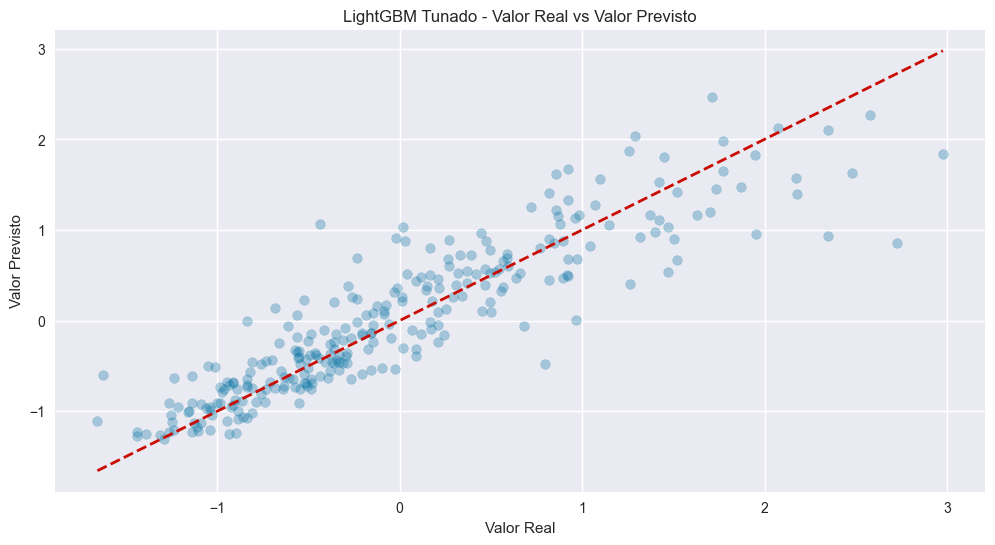

In [173]:
# Visualização das previsões do LightGBM Tunado
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_lgb_tuned, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('LightGBM Tunado - Valor Real vs Valor Previsto')
plt.show()

Agora vamos aplicar as features mais importantes para verificar se há perda de discriminação relevante

In [174]:
# Instanciar o modelo LightGBM
lgb_important = lgb.LGBMRegressor(random_state=42)

# Configuração do RandomizedSearchCV com features selecionadas
lgb_tuned_important = RandomizedSearchCV(
    estimator=lgb_important,
    param_distributions=param_grid_lgb,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo com RandomizedSearchCV
lgb_tuned_important.fit(X_train_important_lgb, y_train)

# Melhor combinação de hiperparâmetros encontrada
best_params_lgb_important = lgb_tuned_important.best_params_
print(f'Melhores hiperparâmetros com features selecionadas: {best_params_lgb_important}')


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 12
[LightGBM] [Info] Start training from score 0.002720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [175]:
# Fazer previsões no conjunto de teste com o melhor modelo
y_pred_lgb_tuned_important = lgb_tuned_important.predict(X_test_important_lgb)

# Calcular o erro quadrático médio (MSE) e o R²
mse_lgb_tuned_important = mean_squared_error(y_test, y_pred_lgb_tuned_important)
r2_lgb_tuned_important = lgb_tuned_important.score(X_test_important_lgb, y_test)

print(f'LightGBM Tunado com Features Selecionadas - Mean Squared Error: {mse_lgb_tuned_important}')
print(f'LightGBM Tunado com Features Selecionadas - R² Score: {r2_lgb_tuned_important}')

LightGBM Tunado com Features Selecionadas - Mean Squared Error: 0.15925856023451326
LightGBM Tunado com Features Selecionadas - R² Score: 0.8095516588817266


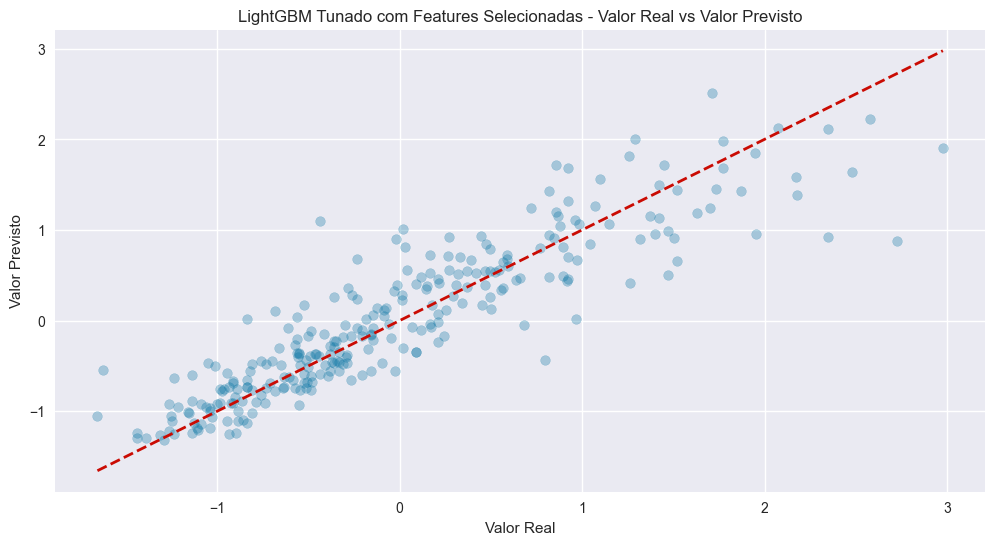

In [176]:
# Visualização das previsões do LightGBM Tunado com as features selecionadas
plt.figure(figsize=(12, 6))

plt.scatter(y_test, y_pred_lgb_tuned_important, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('LightGBM Tunado com Features Selecionadas - Valor Real vs Valor Previsto')
plt.show()

### 6. Construção dos modelos utilizando pycaret

Nesta seção, vamos integrar o PyCaret ao seu fluxo de trabalho para realizar uma análise completa dos dados e construir modelos de regressão. O PyCaret cuidará de muitos detalhes automaticamente, incluindo a preparação dos dados, a seleção de modelos, a otimização de hiperparâmetros e a avaliação dos modelos.

In [177]:
# Configuração da experiência de regressão no PyCaret
exp_reg = setup(data=df, target='price', session_id=42, normalize=True, remove_outliers=True)

In [178]:
# Treinamento e comparação de todos os modelos disponíveis
best_model = compare_models()

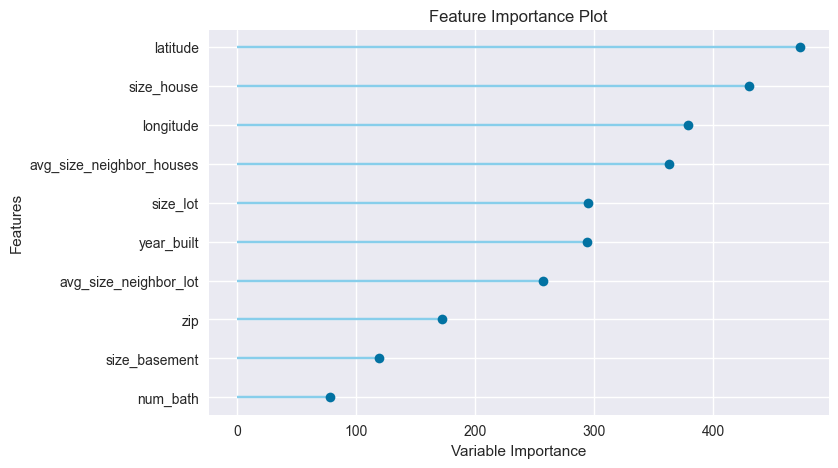

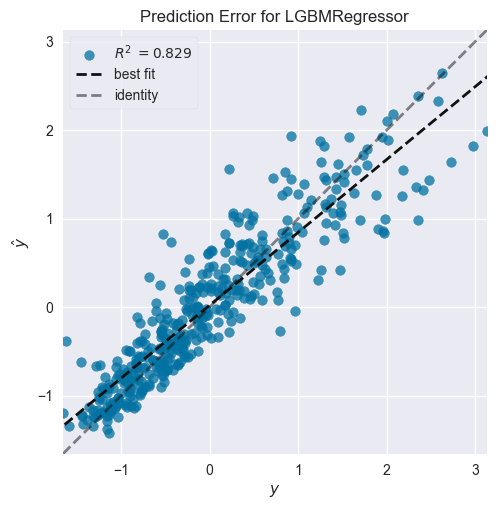

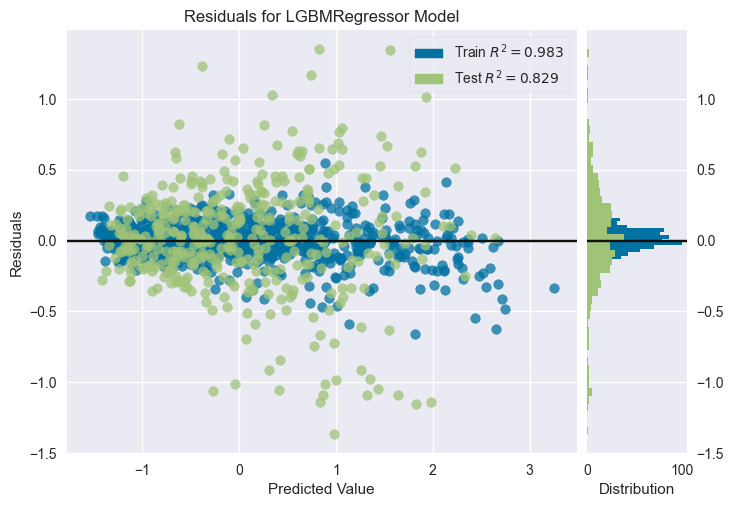

In [179]:
# Interpretação do melhor modelo
plot_model(best_model, plot='feature')
plot_model(best_model, plot='error')
plot_model(best_model, plot='residuals')

In [180]:
# Avaliação do melhor modelo
best_model_results = pull(best_model)

# Extraindo R² e MSE dos resultados do PyCaret
best_model_r2 = best_model_results['R2'].mean()
best_model_mse = best_model_results['MSE'].mean()

In [181]:
# Avaliação do melhor modelo
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [182]:
# Tunnando o melhor modelo
tuned_model = tune_model(best_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


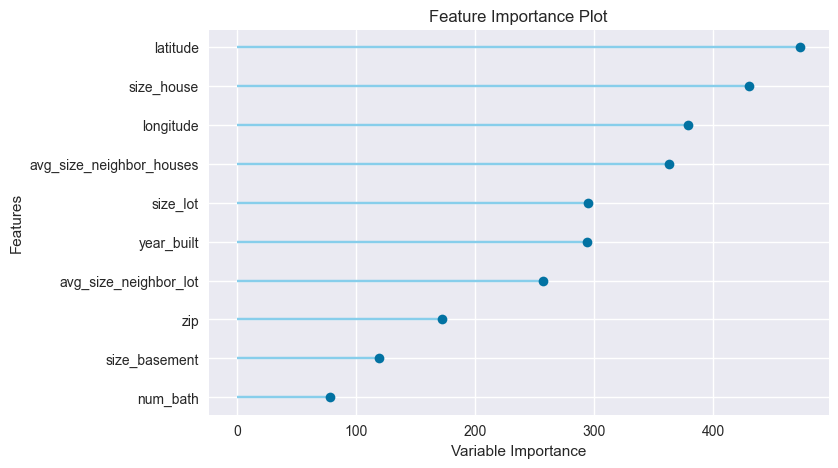

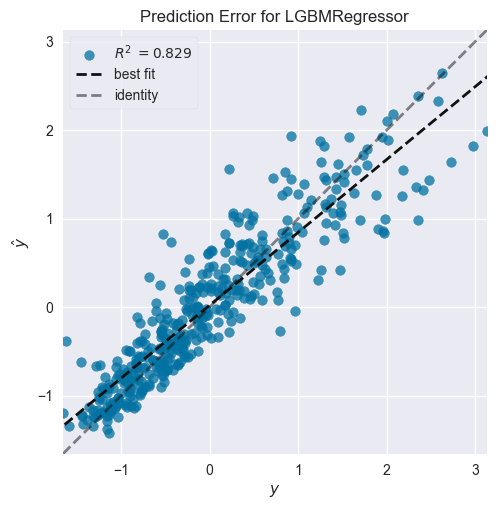

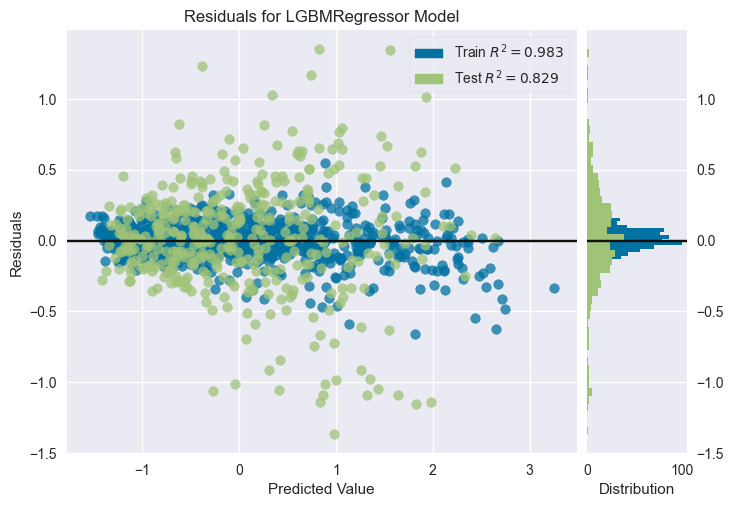

In [183]:
# Interpretação do modelo tunnado
plot_model(tuned_model, plot='feature')
plot_model(tuned_model, plot='error')
plot_model(tuned_model, plot='residuals')

In [184]:
# Avaliação do modelo tunnado
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [185]:
# Avaliação do modelo tunado com PyCaret
tuned_model_results = pull(tuned_model)

# Extraindo R² e MSE dos resultados do PyCaret
tuned_model_r2 = tuned_model_results['R2'].mean()
tuned_model_mse = tuned_model_results['MSE'].mean()

### 7. Resultados obtidos

Vimos que obtivemos diferentes resultados com abordagens distintas

In [187]:
print("Resultados dos modelos de Random Forest:")
print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R² Score: {r2_rf}')
print("")
print(f'Random Forest Tunado - Mean Squared Error: {mse_rf_tuned}')
print(f'Random Forest Tunado - R² Score: {r2_rf_tuned}')
print("")
print(f'Random Forest Tunado com Features Selecionadas - Mean Squared Error: {mse_rf_tuned_important}')
print(f'Random Forest Tunado com Features Selecionadas - R² Score: {r2_rf_tuned_important}')
print("")
print("Resultados dos modelos de LGBM:")
print(f'LightGBM - Mean Squared Error: {mse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')
print("")
print(f'LightGBM Tunado - Mean Squared Error: {mse_lgb_tuned}')
print(f'LightGBM Tunado - R² Score: {r2_lgb_tuned}')
print("")
print(f'LightGBM Tunado com Features Selecionadas - Mean Squared Error: {mse_lgb_tuned_important}')
print(f'LightGBM Tunado com Features Selecionadas - R² Score: {r2_lgb_tuned_important}')

Resultados dos modelos de Random Forest:
Random Forest - Mean Squared Error: 0.15866419223941622
Random Forest - R² Score: 0.8102624300861966

Random Forest Tunado - Mean Squared Error: 0.18354761022606825
Random Forest Tunado - R² Score: 0.7805057522038137

Random Forest Tunado com Features Selecionadas - Mean Squared Error: 0.16663267685870392
Random Forest Tunado com Features Selecionadas - R² Score: 0.8007333681963043

Resultados dos modelos de LGBM:
LightGBM - Mean Squared Error: 0.16307397770713264
LightGBM - R² Score: 0.8049890160494417

LightGBM Tunado - Mean Squared Error: 0.16021159370802313
LightGBM Tunado - R² Score: 0.8084119798353202

LightGBM Tunado com Features Selecionadas - Mean Squared Error: 0.15925856023451326
LightGBM Tunado com Features Selecionadas - R² Score: 0.8095516588817266


In [188]:
print("Resultados dos modelos com PyCaret:")
print(f'Best_model - Resultados: {best_model_results}')
print(f'Tunado_model - Resultados: {tuned_model_results}')

Resultados dos modelos com PyCaret:
Best_model - Resultados:                                     Model     MAE     MSE    RMSE      R2  \
lightgbm  Light Gradient Boosting Machine  0.3174  0.2094  0.4521  0.8022   
et                  Extra Trees Regressor  0.3163  0.2133  0.4554  0.7991   
gbr           Gradient Boosting Regressor  0.3284  0.2202  0.4625  0.7932   
rf                Random Forest Regressor  0.3221  0.2197  0.4618  0.7927   
ada                    AdaBoost Regressor  0.4389  0.3183  0.5614  0.6930   
knn                 K Neighbors Regressor  0.4171  0.3471  0.5861  0.6665   
ridge                    Ridge Regression  0.4506  0.3501  0.5887  0.6624   
lr                      Linear Regression  0.4505  0.3501  0.5887  0.6623   
br                         Bayesian Ridge  0.4513  0.3508  0.5893  0.6618   
huber                     Huber Regressor  0.4481  0.3530  0.5910  0.6601   
dt                Decision Tree Regressor  0.4290  0.3922  0.6226  0.6247   
lar            

### 8. Salva os modelos

Salva os arquivos dos modelos para uso posterior

In [189]:
# Salva o modelo Random Forest Tunado com Features Selecionadas
with open('random_forest_tuned_important.pkl', 'wb') as f:
    pickle.dump(rfr_tuned_important, f)

# Salva o modelo LightGBM Tunado com Features Selecionadas
with open('lightgbm_tuned_important.pkl', 'wb') as f:
    pickle.dump(lgb_tuned_important, f)